In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils
import pickle
from scipy.optimize import minimize

In [2]:
#filename = 'data/forAbhi/All_Data.mat'
filename = 'data/All_Data.mat'
data = scipy.io.loadmat(filename) #complete dataset: velocity 48, contrast 48, Edge velocity 8, Edge contrast 8
T4_arclight = data['data']*100.0
T4_gcamp = data['data2']*100.0
# T4_arclight = T4_arclight[:,0:96]
# T4_gcamp = T4_gcamp[:,0:96]
#first 48 columns [0:47] are orientation velocity data, 
#next 48 columns [48:95] are orientation contrast data,
#next 10 columns [96:105] are edge PDND data

In [3]:
T4_arclight.shape, T4_gcamp.shape

((113, 112), (113, 112))

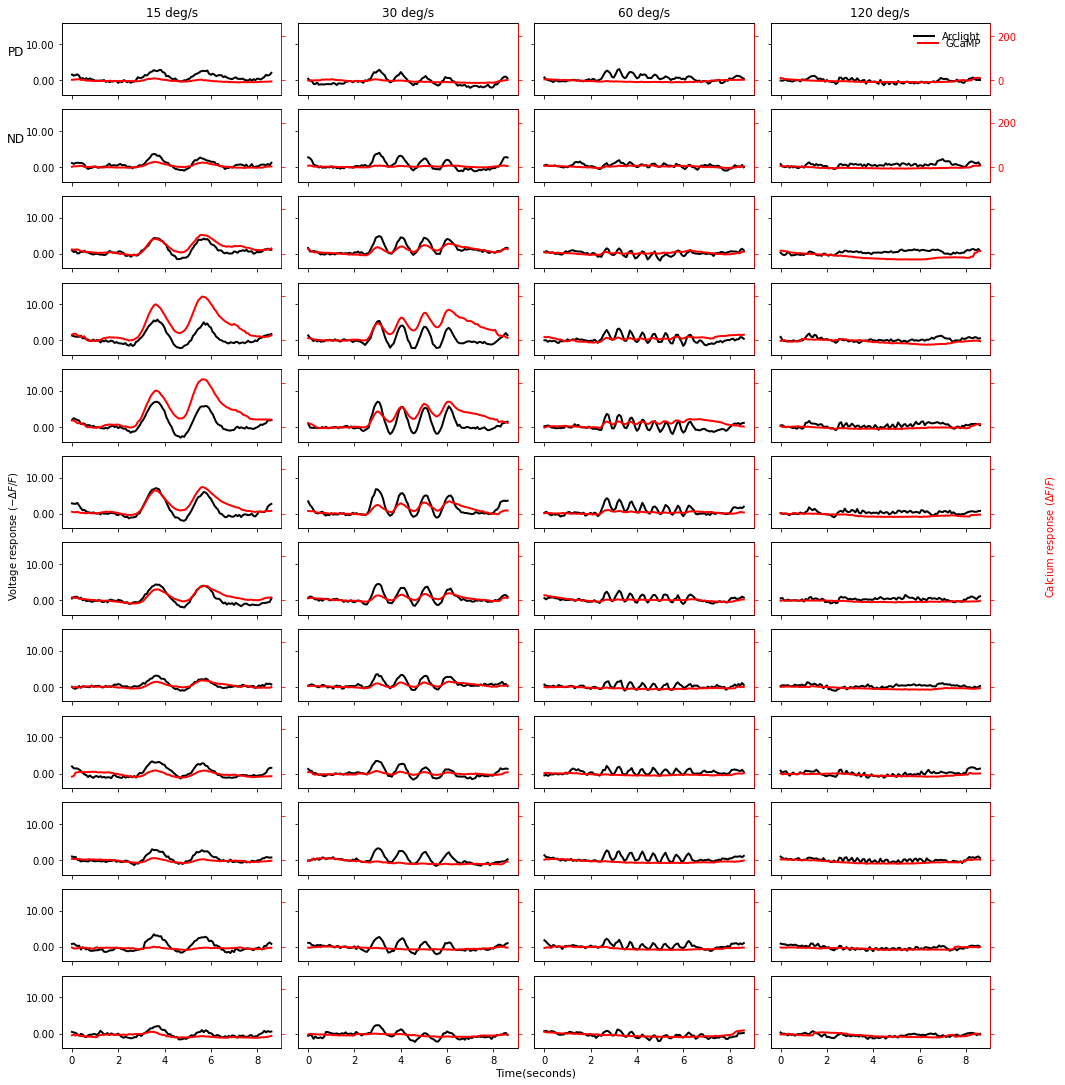

In [36]:
velocity = [15, 30, 60, 120]
#utils.plot_data_twinaxis([T4_arclight[10:,0:8], T4_gcamp[10:,0:8]], ylim=(-0.20,2.50), savefig=True, title='Gratings_SpeedPDND');
#utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-0.04,0.10),ylim2=(-0.30,2.60),savefig=False, title='Ori_Vel');
utils.plot_data_twinaxis([T4_arclight[:,0:48], T4_gcamp[:,0:48]], fig_size=(15,15),speed=velocity,ylim1=(-4,10),ylim2=(-30,260),savefig=False, title='Ori_Vel');

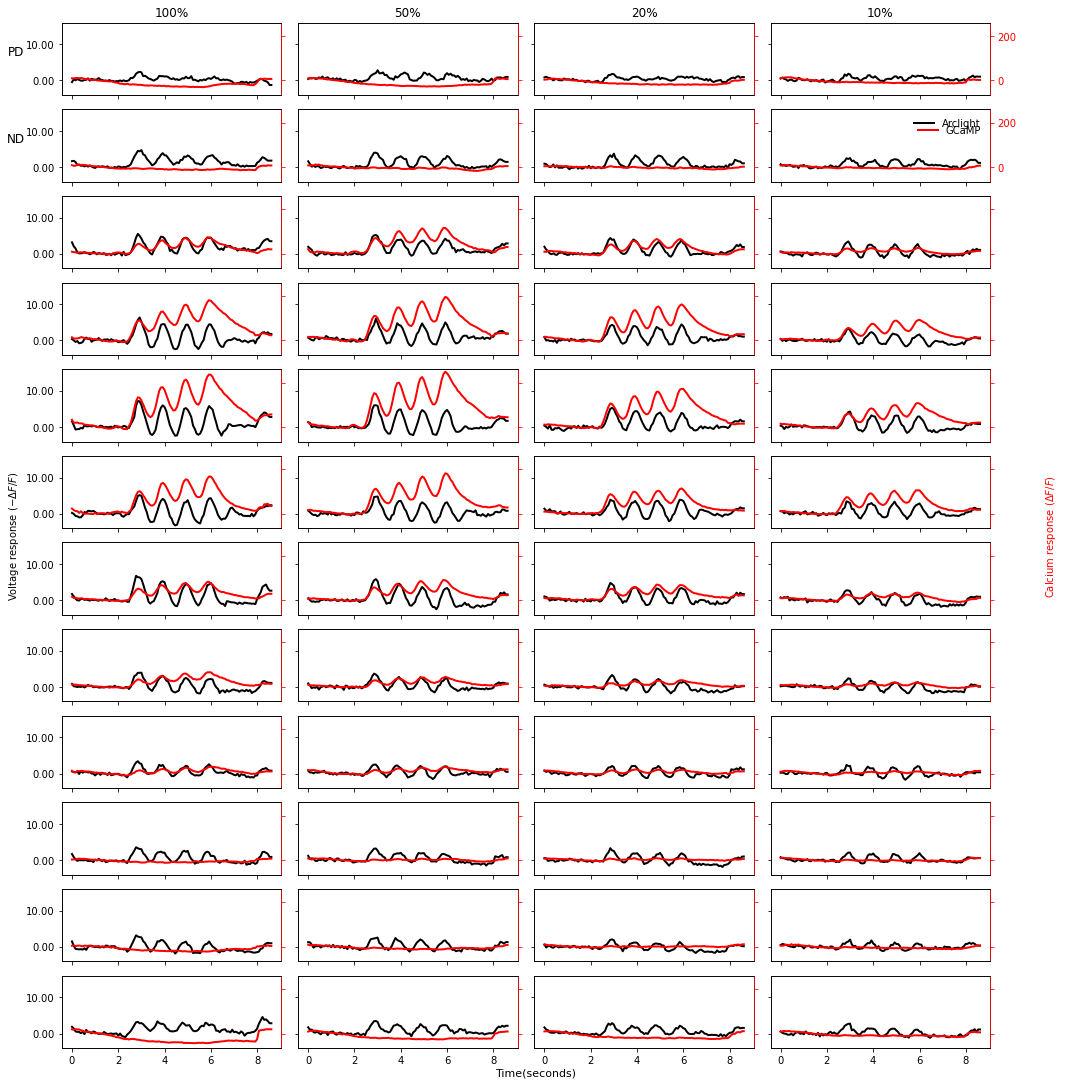

In [37]:
contrast = [100, 50, 20, 10]
#utils.plot_data_twinaxis([T4_arclight[10:,0:8], T4_gcamp[10:,0:8]], ylim=(-0.20,2.50), savefig=True, title='Gratings_SpeedPDND');
#utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-0.04,0.10),ylim2=(-0.30,2.60),savefig=False, title='Ori_Vel');
utils.plot_data_twinaxis([T4_arclight[:,48:96], T4_gcamp[:,48:96]], fig_size=(15,15),speed=contrast,contrast = True,ylim1=(-4,10),ylim2=(-30,260),savefig=False, title='Ori_Vel');

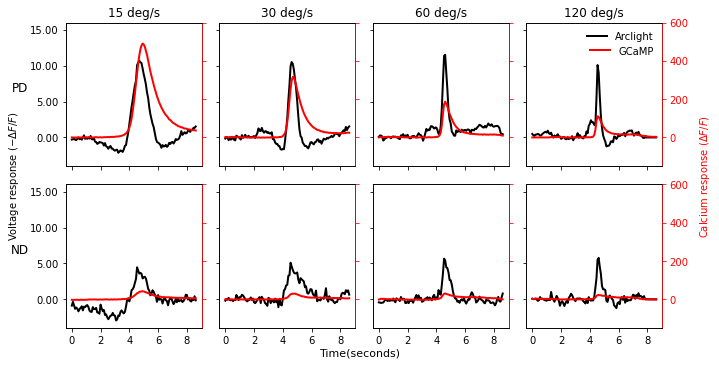

In [38]:
velocity=[15,30,60,120]
utils.plot_data_twinaxis([T4_arclight[:,96:104], T4_gcamp[:,96:104]],speed=velocity,c=['k','r'],ylim1=(-4,10),ylim2=(-20,600))

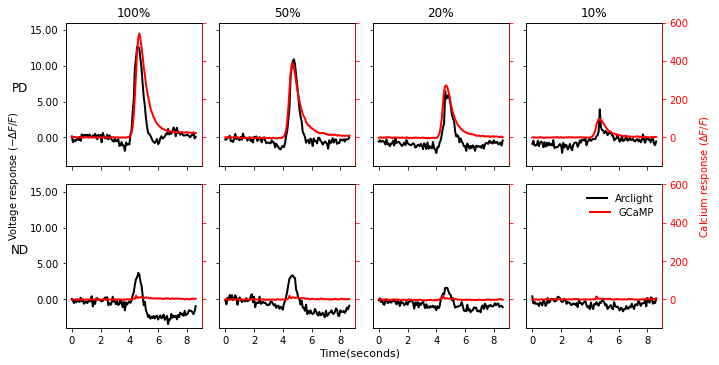

In [39]:
contrast = [100, 50, 20, 10]
utils.plot_data_twinaxis([T4_arclight[:,104:112], T4_gcamp[:,104:112]],speed=contrast,contrast=True,c=['k','r'],ylim1=(-4,10),ylim2=(-20,600))

In [33]:
T4_arclight.min(), T4_arclight.max()

(-3.46257852983738, 12.604759632498)

In [4]:
global p_bounds 

#bounds on parameters (tauhp, thres, taulp1, taulp2, gain, shift)
p_bounds = ((0,1000),(T4_arclight.min()*100, T4_arclight.max()*100),(0,300),(0,2000),(0,1000),(-5,0))

#bounds on parameters for L model (tauhp, thres, taulp1, taulp2, gain1, gain2 shift)
p_bounds_L = ((0,1000),(T4_arclight.min()*100, T4_arclight.max()*100),(0,300),(0,2000),(0,1000),(0,1000),(-5,0))

In [5]:
def M_model(x, p, dt=(1/13.0), plot=False):
    """x is Arclight data. p is list of parameters. dt is timestep"""
    (tauhp, thres, taulp1, taulp2, gain, shift) = p
    x_highpass = highpass(x.copy(), tauhp/100.0, dt)
    x_thres = threshold_cut(x_highpass.copy(), thres/100.0)
    x_thres_lp1 = lowpass(x_thres.copy(), taulp1/100.0, dt)
    x_thres_lp2 = lowpass(x_thres.copy(), taulp2/100.0, dt)
    x_1 = x_thres_lp1 * x_thres_lp2
    x_2 = x_1 * gain
    y = np.roll(x_2, int(shift), axis=0)
    if plot==True:
        utils.plot_data([x, x_thres, x_1, x_2, y], c=['k','grey','g','brown','r']);
    return y

def L_model(x, p, dt=(1/13.0), plot=False):
    """x is Arclight data. p is list of parameters. dt is timestep"""
    (tauhp, thres, taulp1, taulp2, gain1, gain2, shift) = p
    x_highpass = highpass(x.copy(), tauhp/100.0, dt)
    x_thres = threshold_cut(x_highpass.copy(), thres/100.0)
    x_thres_lp1 = lowpass(x_thres.copy(), taulp1/100.0, dt)*gain1
    x_thres_lp2 = lowpass(x_thres.copy(), taulp2/100.0, dt)*gain2
    x_1 = x_thres_lp1 + x_thres_lp2
    y = np.roll(x_1, int(shift), axis=0)
    if plot==True:
        utils.plot_data([x, x_thres, x_1, x_2, y], c=['k','grey','g','brown','r']);
    return y

In [6]:
def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = thres
    return x_copy 

def create_random_params():
    p = [np.random.uniform(bounds[0], bounds[1]) for bounds in p_bounds]
    #print(p)
    return p  

def calc_error(p):
    T4Ca_model = M_model(T4_arclight, p)
    #error = np.mean(np.sqrt(np.mean((T4_gcamp-T4Ca_model)**2,axis=0)))
    #error = (T4_gcamp[10:100,:]-T4Ca_model[10:100,:])**2
    #error = np.mean(np.sqrt(np.mean((T4_gcamp[10:100,:]-T4Ca_model[10:100,:])**2,axis=0)))/np.mean(np.sqrt(np.mean(T4_gcamp[10:100,:]**2,axis=0)))
    error = np.sum((T4_gcamp[10:100,:]-T4Ca_model[10:100,:])**2)
    return error

def fit_params():
    p = create_random_params() #creates random parameter values
    #options = {'maxiter':5000} #maximum number of iterations
    res = minimize(calc_error, p, bounds=p_bounds)#options=options
    success = res.success
    if success:
        print('Optimisation successful')
    else:
        print('Optimisation not succesfull')
    p = res.x
    error = calc_error(p)
    print('Remaining Error: ', format(calc_error(p),".2f"))
    print(res)
    return p, error, success

In [7]:
def many_runs(n):
    (p_list, err_list) = ([],[]) 
    for i in range(n):
        print('run : '+str(i))
        (par, err, success) = fit_params()
        if success:
            print(par)
            p_list.append(par)
            err_list.append(err)
    return p_list, err_list
    

In [8]:
para_list, err_list = many_runs(300)

run : 0
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,   -3.53250959])
[   0.         -346.25785298  300.         2000.            0.
   -3.53250959]
run : 1
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,  2.00000000e+03,
        0.00000000e+00, -1.91866608e+00])
[ 0.00000000e+00 -3

Optimisation successful
Remaining Error:  19281840.25
      fun: 19281840.247623425
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.37253297, -0.        , -0.        ,  0.        ,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 3
     njev: 9
   status: 0
  success: True
        x: array([ 0.00000000e+00,  1.26047596e+03,  3.00000000e+02,  2.00000000e+03,
        8.95117892e-02, -2.22735654e+00])
[ 0.00000000e+00  1.26047596e+03  3.00000000e+02  2.00000000e+03
  8.95117892e-02 -2.22735654e+00]
run : 17
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,

Optimisation successful
Remaining Error:  4736115.60
      fun: 4736115.600517204
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([393.29749072, -35.11085816,  -7.3574425 ,  -5.96045975,
         7.26431032,  -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 896
      nit: 58
     njev: 128
   status: 0
  success: True
        x: array([ 29.60169386, -30.14668284, 197.47297982, 197.75927696,
       344.78812946,  -1.38937631])
[ 29.60169386 -30.14668284 197.47297982 197.75927696 344.78812946
  -1.38937631]
run : 36
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,  2.00000000e+03,
        0.

Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  0.00000000e+00,  2.00000000e+03,
        0.00000000e+00, -1.10897326e-01])
[ 0.00000000e+00 -3.46257853e+02  0.00000000e+00  2.00000000e+03
  0.00000000e+00 -1.10897326e-01]
run : 54
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,   -3.17793766])
[   0.

Optimisation successful
Remaining Error:  19281840.25
      fun: 19281840.24762343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.37253297, -0.        , -0.        , -0.37252903,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 3
     njev: 9
   status: 0
  success: True
        x: array([ 0.00000000e+00,  1.26047596e+03,  3.00000000e+02,  2.00000000e+03,
        8.95117882e-02, -3.43133881e+00])
[ 0.00000000e+00  1.26047596e+03  3.00000000e+02  2.00000000e+03
  8.95117882e-02 -3.43133881e+00]
run : 74
Optimisation successful
Remaining Error:  5526009.93
      fun: 5526009.931218285
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.117587  , -5.21540599, -0.18626437, -0.37252873,  0.09313218,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 763
      nit: 62
     njev: 109
   status: 0
  success: True
        x: ar

Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,   -3.15434216])
[   0.         -346.25785298  300.         2000.            0.
   -3.15434216]
run : 90
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,  2.00000000e+03,
        0.00000000e+00, -1.82646818e+00])
[ 0.00000000e+00 -3.462578

Optimisation successful
Remaining Error:  4408201.56
      fun: 4408201.555431782
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.9313225 , -3.63215774,  0.09313218,  0.        ,  0.09313218,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 938
      nit: 75
     njev: 134
   status: 0
  success: True
        x: array([ 36.2900764 , -34.59746666, 236.77090755, 236.73482954,
       359.95826989,  -2.69158027])
[ 36.2900764  -34.59746666 236.77090755 236.73482954 359.95826989
  -2.69158027]
run : 109
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,  

Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,  2.00000000e+03,
        0.00000000e+00, -1.40956800e+00])
[ 0.00000000e+00 -3.46257853e+02  3.00000000e+02  2.00000000e+03
  0.00000000e+00 -1.40956800e+00]
run : 125
Optimisation successful
Remaining Error:  19281840.25
      fun: 19281840.24762342
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.        , -0.        , -0.        ,  0.74505806,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 3
     njev: 9
   status: 0
  success: True
        x: array([ 0.00000000e+00,  1.26047596e+03,  3.00000000e+02,

Optimisation successful
Remaining Error:  4883165.69
      fun: 4883165.687079043
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 75.8096513 , -54.48236611,  -6.2398563 ,  16.48439649,
         4.37721263,  -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 665
      nit: 40
     njev: 95
   status: 0
  success: True
        x: array([ 52.23616689, -38.67927203, 220.35397364, 700.28051373,
       554.50079076,  -4.16461785])
[ 52.23616689 -38.67927203 220.35397364 700.28051373 554.50079076
  -4.16461785]
run : 146
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.      

Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([ 0.00000000e+00, -3.46257853e+02,  3.00000000e+02,  2.00000000e+03,
        0.00000000e+00, -3.64518763e-01])
[ 0.00000000e+00 -3.46257853e+02  3.00000000e+02  2.00000000e+03
  0.00000000e+00 -3.64518763e-01]
run : 162
Optimisation successful
Remaining Error:  5526009.94
      fun: 5526009.936783267
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([13.41104396, -0.9313225 , -1.21071839, -0.93132184,  1.02445402,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 805
      nit: 80
     njev: 115
   status: 0
  success: True
        x: array([ 26.75767847, -26.09687419, 174.73385882, 174.7

Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,   -2.40182156])
[   0.         -346.25785298  300.         2000.            0.
   -2.40182156]
run : 178
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.        ,   -4.44919638])
[   0.         -346.25785298  300.   

Optimisation successful
Remaining Error:  4480307.78
      fun: 4480307.775845714
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.45057998, 15.08742446,  0.27939655,  0.18626437, -0.09313218,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 980
      nit: 79
     njev: 140
   status: 0
  success: True
        x: array([ 43.64819545, -38.44207827, 286.54254595, 286.54028121,
       393.79431419,  -3.31313502])
[ 43.64819545 -38.44207827 286.54254595 286.54028121 393.79431419
  -3.31313502]
run : 194
Optimisation successful
Remaining Error:  4408201.56
      fun: 4408201.557284301
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.1862645 , -4.00468674, -0.27939655, -0.27939655,  0.18626437,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 805
      nit: 65
     njev: 115
   status: 0
  success: True
        x: array([ 36.28976604, -34.59793177,

Optimisation successful
Remaining Error:  5526009.93
      fun: 5526009.93037932
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.745058  , -6.05359623, -0.09313218, -0.27939655,  0.        ,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 938
      nit: 84
     njev: 134
   status: 0
  success: True
        x: array([ 26.75764834, -26.0963967 , 174.74618987, 174.75083747,
       316.77002662,  -0.80669453])
[ 26.75764834 -26.0963967  174.74618987 174.75083747 316.77002662
  -0.80669453]
run : 209
Optimisation successful
Remaining Error:  4408205.66
      fun: 4408205.660304942
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.51457074,  0.09313225, -0.46566092, -0.46566092,  0.27939655,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 679
      nit: 68
     njev: 97
   status: 0
  success: True
        x: array([ 36.45577401, -34.79994452, 2

Optimisation successful
Remaining Error:  11871190.94
      fun: 11871190.937427238
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.862645  ,   0.        ,   0.        ,   0.37252873,
       -36.13528723,  -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 588
      nit: 50
     njev: 84
   status: 0
  success: True
        x: array([ 1.21315640e+01, -3.46257853e+02,  1.36856323e+02,  1.36859230e+02,
        1.00000000e+03, -7.33286779e-02])
[ 1.21315640e+01 -3.46257853e+02  1.36856323e+02  1.36859230e+02
  1.00000000e+03 -7.33286779e-02]
run : 224
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  285.79889

Optimisation successful
Remaining Error:  4878409.98
      fun: 4878409.975938351
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.372529  ,  -1.490116  , -10.52393674,   0.27939655,
        -0.09313218,  -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 616
      nit: 52
     njev: 88
   status: 0
  success: True
        x: array([ 50.86148775, -39.19455196, 300.        , 385.61111641,
       427.85837084,  -4.63643201])
[ 50.86148775 -39.19455196 300.         385.61111641 427.85837084
  -4.63643201]
run : 244
Optimisation successful
Remaining Error:  4480262.59
      fun: 4480262.587069441
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([45.35540563, 32.50315516,  0.        , -0.09313218, -0.37252873,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 735
      nit: 63
     njev: 105
   status: 0
  success: True
        x: array([ 43.47142841, -38.2457

Optimisation successful
Remaining Error:  4408201.57
      fun: 4408201.568062954
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-29.98858442,  13.69044071,   1.30385057,   1.39698275,
        -1.02445402,  -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 896
      nit: 73
     njev: 128
   status: 0
  success: True
        x: array([ 36.28826248, -34.59783647, 236.76751886, 236.74312242,
       359.97851974,  -2.9348429 ])
[ 36.28826248 -34.59783647 236.76751886 236.74312242 359.97851974
  -2.9348429 ]
run : 261
Optimisation successful
Remaining Error:  21320568.41
      fun: 21320568.405315343
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([   0.        , -346.25785298,  300.        , 2000.        ,
          0.     

Optimisation successful
Remaining Error:  5526009.94
      fun: 5526009.935593776
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.98023199, -6.51925748, -0.5587931 , -0.65192529,  0.18626437,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 630
      nit: 65
     njev: 90
   status: 0
  success: True
        x: array([ 26.75786829, -26.0973408 , 174.75011935, 174.75023681,
       316.77395359,  -0.56194338])
[ 26.75786829 -26.0973408  174.75011935 174.75023681 316.77395359
  -0.56194338]
run : 276
Optimisation successful
Remaining Error:  19281840.25
      fun: 19281840.247623425
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0., -0., -0., -0.,  0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 56
      nit: 3
     njev: 8
   status: 0
  success: True
        x: array([ 0.00000000e+00,  1.26047596e+03,  3.00000000e+02,  2.00000000e+03,
        8.951178

Optimisation successful
Remaining Error:  7703984.44
      fun: 7703984.437955794
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3938.93816995, 64047.42068603, -2700.27644942,   260.95934516,
        1965.4616023 ,    -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 287
      nit: 16
     njev: 41
   status: 0
  success: True
        x: array([ 1.24086374e+02,  1.39363207e+01,  5.25356167e+01,  1.42169334e+03,
        1.52115575e+02, -9.15616884e-01])
[ 1.24086374e+02  1.39363207e+01  5.25356167e+01  1.42169334e+03
  1.52115575e+02 -9.15616884e-01]
run : 295
Optimisation successful
Remaining Error:  4408205.67
      fun: 4408205.667815644
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.63684448, -4.56348024,  0.46566092,  0.65192529, -0.74505747,
       -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 700
      nit: 67
     njev: 100
   status: 0
  succes

In [9]:
# model_para = np.load('model_parameters/scipymini_newmodel_alldatasetcombined.npy')
# print(f'(tauhp, thres, taulp1, taulp2, gain, shift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]/100:.2f}, {model_para[3]/100:.2f}, {model_para[4]:.2f}, {model_para[5]:.2f})')

In [11]:
np.argmin(err_list)

108

In [13]:
model_para = para_list[np.argmin(err_list)]
print(np.min(err_list))
print(np.min(err_list) / np.sum((T4_gcamp[10:100,:])**2))
#print(f'(thres, taulp1, gain1, taulp2, gain2, tshift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]:.2f}, {model_para[3]/100:.2f}, {model_para[4]:.2f}, {model_para[5]:.2f})')
#print(f'(thres, tauhp, taulp1, gain1, taulp2, gain2, tshift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]/100:.2f}, {model_para[3]:.2f}, {model_para[4]/100:.2f}, {model_para[5]:.2f}, {model_para[6]:.2f})')
print(f'(tauhp, thres, taulp1, taulp2, gain, shift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]/100:.2f}, {model_para[3]/100:.2f}, {model_para[4]:.2f}, {model_para[5]:.2f})')

#print(model_para/100) # (thres, taulp1, gain1, taulp2, gain2, tshift)

4408201.555431782
0.20675816289835833
(tauhp, thres, taulp1, taulp2, gain, shift) = (0.36, -0.35,2.37, 2.37, 359.96, -2.69)


In [14]:
#model_p = fit_params()
T4Ca_model = M_model(T4_arclight, model_para, plot=False)
#plot_data([T4_Gcamp, T4Ca_model])

In [15]:
np.sum((T4_gcamp[10:100,:]-T4Ca_model[10:100,:])**2) / np.sum((T4_gcamp[10:100,:])**2)

0.20675816289835833

In [30]:
err_array = np.array(err_list) / np.sum((T4_gcamp[10:100,:])**2)
idx = np.argpartition(err_list, 10)
err_array[idx[:10]]

array([0.20675816, 0.20675816, 0.20675816, 0.20675816, 0.20675836,
       0.20675816, 0.20675836, 0.20675872, 0.20675836, 0.20675872])

In [31]:
from scipy.stats import sem
np.mean(err_array[idx[:10]]), np.std(err_array[idx[:10]]), sem(err_array[idx[:10]])

(0.20675833136387256, 2.0955077327073957e-07, 6.985025775691318e-08)

In [32]:
para_array = np.array(para_list)
para_array[:,:5] = para_array[:,:5]/100.0
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
para_array[idx[:10]]

array([[0.363, -0.346, 2.367, 2.368, 3.600, -2.634],
       [0.363, -0.346, 2.368, 2.367, 3.600, -2.692],
       [0.363, -0.346, 2.368, 2.367, 3.600, -2.935],
       [0.363, -0.346, 2.368, 2.367, 3.599, -2.687],
       [0.365, -0.348, 2.375, 2.375, 3.604, -2.150],
       [0.363, -0.346, 2.367, 2.368, 3.600, -2.573],
       [0.365, -0.348, 2.376, 2.375, 3.604, -2.232],
       [0.364, -0.349, 2.379, 2.378, 3.617, -2.055],
       [0.365, -0.348, 2.375, 2.376, 3.604, -2.079],
       [0.364, -0.349, 2.378, 2.379, 3.618, -2.301]])

In [11]:
# T4_gcamp = T4_gcamp / 100.0
# T4Ca_model = T4Ca_model / 100.0

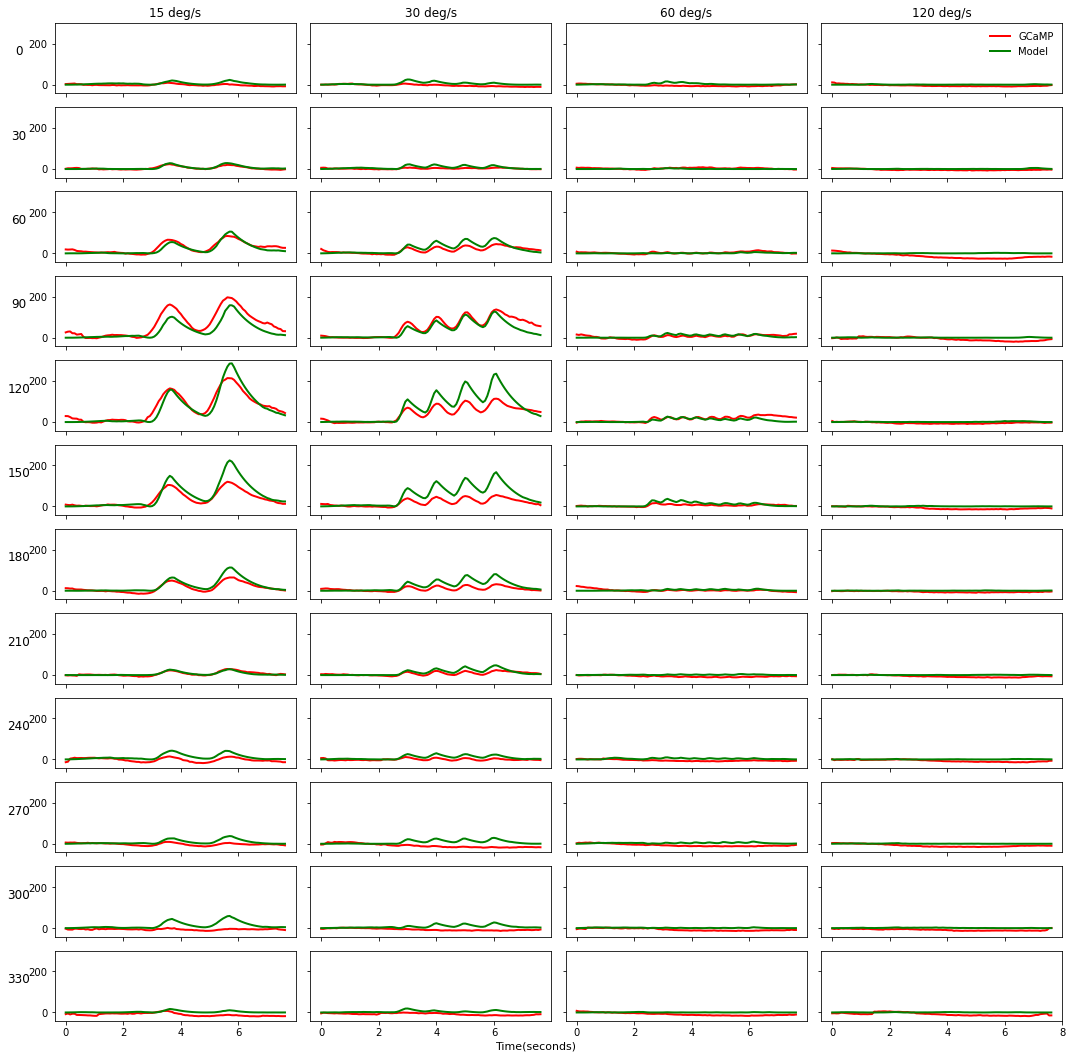

In [16]:
velocity = [15, 30, 60, 120]
utils.plot_data([T4_gcamp[:100,0:48], T4Ca_model[:100,0:48]], ori=True,label=['GCaMP','Model'],c=['r','g'],fig_size=(15,15),speed=velocity,savefig=False, title='Ori_Vel');
#utils.plot_data_twinaxis([T4_gcamp[0:107,0:48], T4Ca_model[0:107,0:48]],speed=velocity,c=['r','g'])
#plt.savefig('figures/scipymini_wholedatasetfit/Ori_Velocity_model.pdf',dpi=1000)

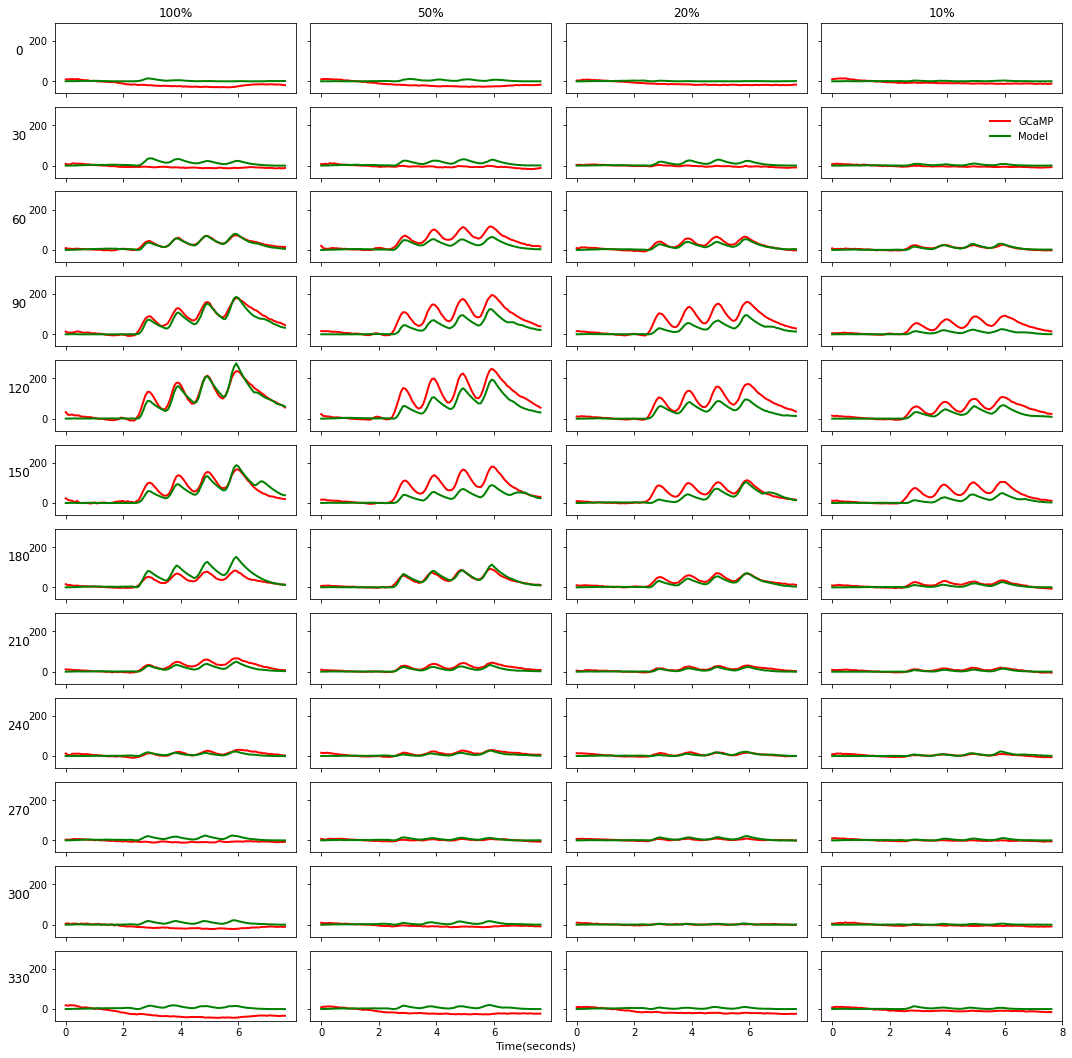

In [17]:
contrast = [100, 50, 20, 10]
#utils.plot_data_twinaxis([T4_arclight[10:,0:8], T4_gcamp[10:,0:8]], ylim=(-0.20,2.50), savefig=True, title='Gratings_SpeedPDND');
#utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-0.04,0.10),ylim2=(-0.30,2.60),savefig=False, title='Ori_Vel');
utils.plot_data([T4_gcamp[:100,48:96], T4Ca_model[:100,48:96]], ori=True,contrast=True,label=['GCaMP','Model'],c=['r','g'], fig_size=(15,15),speed=contrast,savefig=False, title='Ori_Vel');
#plt.savefig('figures/scipymini_wholedatasetfit/Ori_Contrast_model.pdf',dpi=1000)

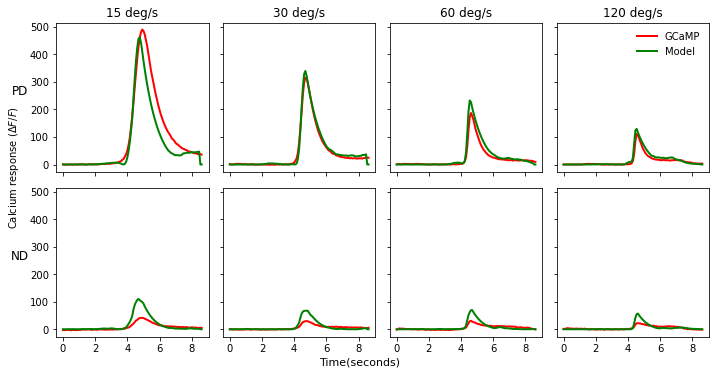

In [18]:
velocity=[15,30,60,120]
utils.plot_data([T4_gcamp[:,96:104], T4Ca_model[:,96:104]], label=['GCaMP','Model'],c=['r','g'],speed=velocity)
#plt.savefig('figures/scipymini_wholedatasetfit/EdgePDND_model.pdf',dpi=1000)

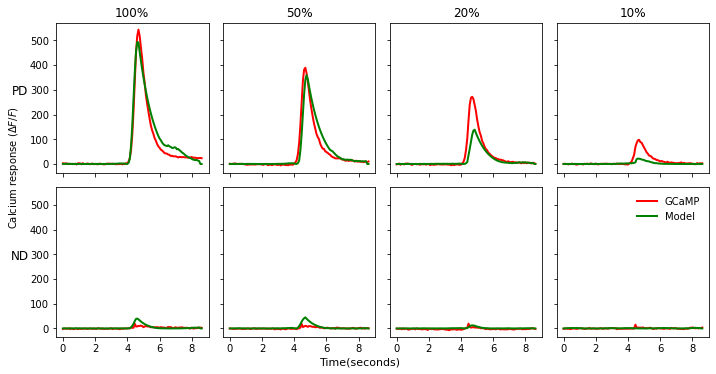

In [19]:
contrast = [100, 50, 20, 10]
utils.plot_data([T4_gcamp[:,104:112], T4Ca_model[:,104:112]], label=['GCaMP','Model'],speed=contrast,contrast=True,c=['r','g'])

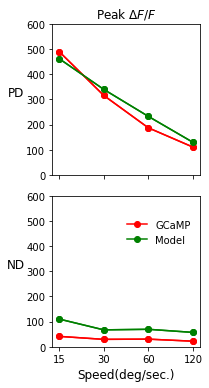

In [20]:
data_list = [T4_gcamp[:,96:104], T4Ca_model[:,96:104]]
velocity = [15, 30, 60, 120]
utils.plot_modelpeaktuning(data_list, speed=velocity, ylim1=(0,600),ylim2=(0.0,600.0),color=['r','g'],title='',savefig=False)
#plt.savefig('figures/scipymini_wholedatasetfit/EdgePDND_peaktuning.pdf',dpi=1000)

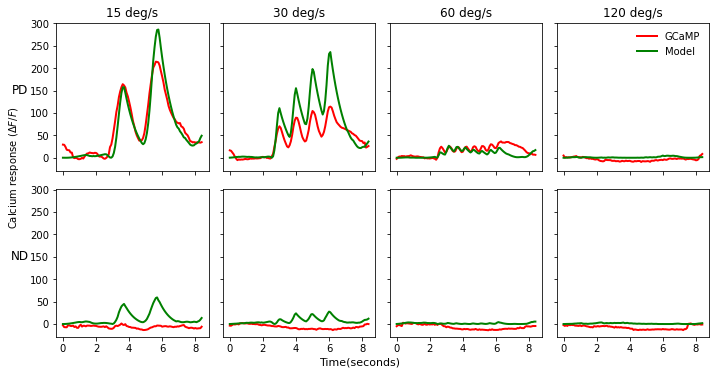

In [21]:
velocity=[15,30,60,120]
utils.plot_data([T4_gcamp[:110,[16,17,18,19,40,41,42,43]], T4Ca_model[:110,[16,17,18,19,40,41,42,43]]], label=['GCaMP','Model'],c=['r','g'],speed=velocity)
#plt.savefig('figures/scipymini_wholedatasetfit/GratingsPDND_model.pdf',dpi=1000)

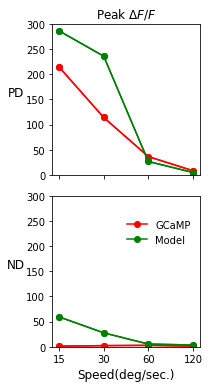

In [23]:
data_list = [T4_gcamp[:110,[16,17,18,19,40,41,42,43]], T4Ca_model[:110,[16,17,18,19,40,41,42,43]]]
velocity = [15, 30, 60, 120]
utils.plot_modelpeaktuning(data_list, speed=velocity, ylim1=(0,300),ylim2=(0.0,300),color=['r','g'],title='',savefig=False)
#plt.savefig('figures/scipymini_wholedatasetfit/GratingsPDND_peaktuning.pdf',dpi=1000)

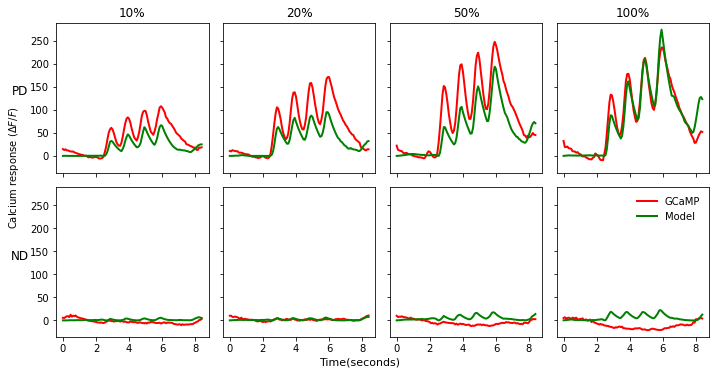

In [24]:
contrast=[10,20,50,100]
utils.plot_data([T4_gcamp[:110,[67,66,65,64,91,90,89,88]], T4Ca_model[:110,[67,66,65,64,91,90,89,88]]], label=['GCaMP','Model'],c=['r','g'],speed=contrast,contrast=True)
#plt.savefig('figures/scipymini_wholedatasetfit/ContrastPDND_model.pdf',dpi=1000)

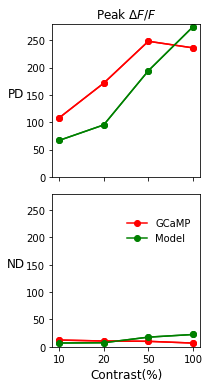

In [25]:
data_list = [T4_gcamp[:110,[67,66,65,64,91,90,89,88]], T4Ca_model[:110,[67,66,65,64,91,90,89,88]]]
contrast = [10,20,50,100]
utils.plot_modelpeaktuning(data_list, speed=contrast, contrast=True,ylim1=(0,280),ylim2=(0.0,280),color=['r','g'],title='',savefig=False)
#plt.savefig('figures/scipymini_wholedatasetfit/ContrastPDND_peaktuning.pdf',dpi=1000)

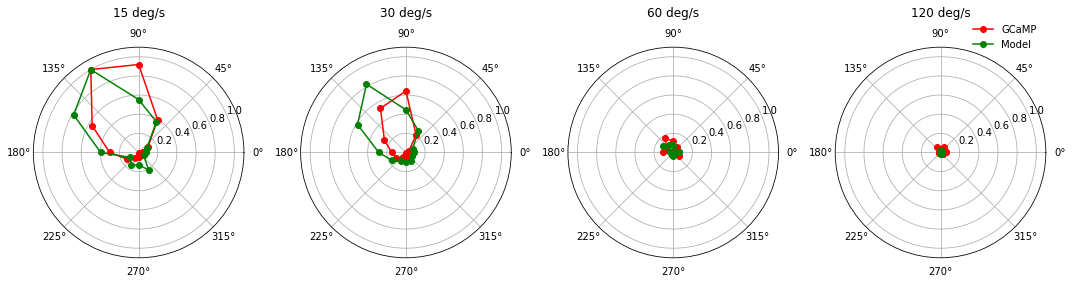

In [26]:
data_list = [T4_gcamp[:,0:48], T4Ca_model[:105,0:48]]
velocity = [15, 30, 60, 120]
peak_tuning = utils.calc_peaktuning(data_list, speed=velocity)
utils.plot_oripeaktuning(data_list,speed=velocity, label=['GCaMP','Model'],fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['r','g'],title='Speed_Ori_Tuning');
#plt.savefig('figures/scipymini_wholedatasetfit/OriVelPolar_model.pdf',dpi=1000)

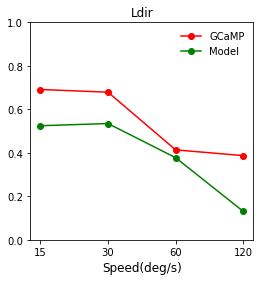

In [27]:
utils.plot_Ldir_mag(peak_tuning, title='Ldir_Speed_Ori_Tuning',savefig=False);
#plt.savefig('figures/scipymini_wholedatasetfit/OriVelLdir_model.pdf',dpi=1000)

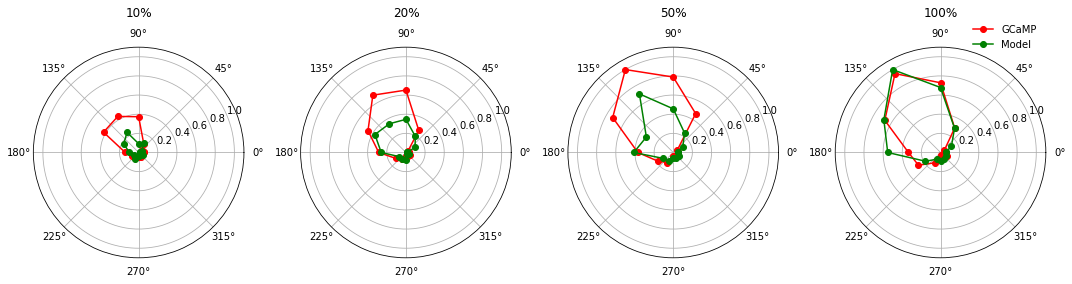

In [28]:
data_list = [T4_gcamp[:,48:96], T4Ca_model[:105,48:96]]
#velocity = [15, 30, 60, 120]
contrast = [10, 20, 50, 100]
peak_tuning = utils.calc_peaktuning(data_list, speed=contrast, contrast=True)
utils.plot_oripeaktuning(data_list,speed=contrast, label=['GCaMP','Model'],contrast=True,fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['r','g'],title='Speed_Ori_Tuning');
#plt.savefig('figures/scipymini_wholedatasetfit/OriContrastPolar_model.pdf',dpi=1000)

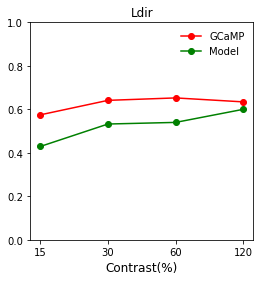

In [29]:
utils.plot_Ldir_mag(peak_tuning, title='',contrast=True,savefig=False);
#plt.savefig('figures/scipymini_wholedatasetfit/OriContrastLdir_model.pdf',dpi=1000)

In [18]:
save_modeldata = True
if save_modeldata:
    np.save('/Volumes/Elements/Project_T4_VoltageCalcium/PaperFigures/data/modeldata/T4Ca_model.npy',T4Ca_model)

In [63]:
save_para = True
if save_para:
    np.save('model_parameters/scipymini_newmodel_alldatasetcombined.npy',model_para)